In [1]:
import os
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn/'
checkpoints_dir = f'{engram_dir}checkpoints/'

# All, feedback weights

In [3]:
tensorboard_dir = f'{engram_dir}tensorboard/'

ScalarEvent(wall_time=1660706159.3805652, step=36199, value=504.6786193847656)
ScalarEvent(wall_time=1660706087.7719336, step=49, value=21.763240814208984)
ScalarEvent(wall_time=1660706087.7723281, step=49, value=572.2852172851562)


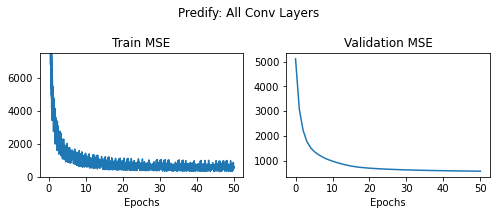

In [7]:
tfdir = tensorboard_dir + 'pnet/'
tfdir_files = os.listdir(tfdir)
if len(tfdir_files) > 1:
    print('More than one TF file; check it is correct.')
tffile = tfdir + tfdir_files[0]
ea = event_accumulator.EventAccumulator(tffile)
ea.Reload()

print(ea.Scalars('MSE Train/Sum')[-1])
print(ea.Scalars('MSE Eval/PCoder3')[-1])
print(ea.Scalars('MSE Eval/Sum')[-1])

fig, axs = plt.subplots(1, 2, figsize = (7, 3))
train_loss = [e.value for e in ea.Scalars('MSE Train/Sum')]
eval_loss = [e.value for e in ea.Scalars('MSE Eval/Sum')]
axs[0].plot(np.linspace(0, len(eval_loss), len(train_loss)), train_loss)
axs[0].set_title('Train MSE')
axs[0].set_xlabel('Epochs')
axs[0].set_ylim(0, 7500)
axs[1].plot(np.linspace(0, len(eval_loss), len(eval_loss)), eval_loss)
axs[1].set_title('Validation MSE')
axs[1].set_xlabel('Epochs')
plt.suptitle('Predify: All Conv Layers')
plt.tight_layout()
plt.show()

# Hyperparameters, separate

In [9]:
plot_ci = True

In [10]:
lr = 0.01

In [11]:
tensorboard_dir = f'{engram_dir}tensorboard/test_lr_{lr}x/'

hyper_Babble8Spkr_snr-6.0


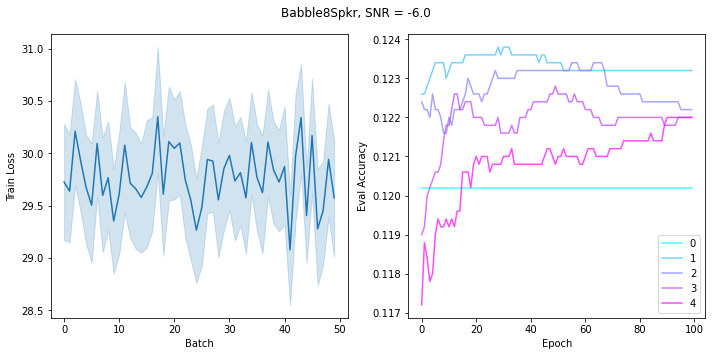




hyper_pinkNoise_snr3.0


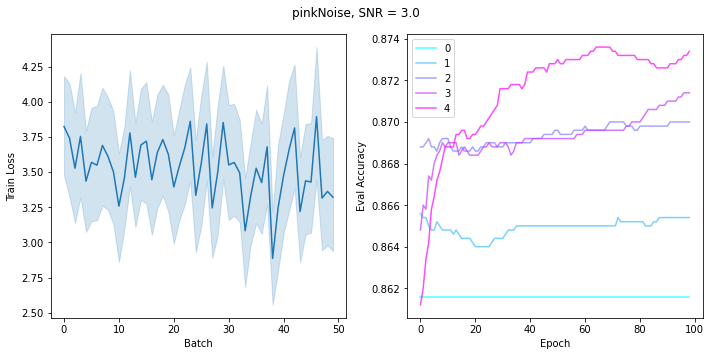




hyper_pinkNoise_snr-6.0


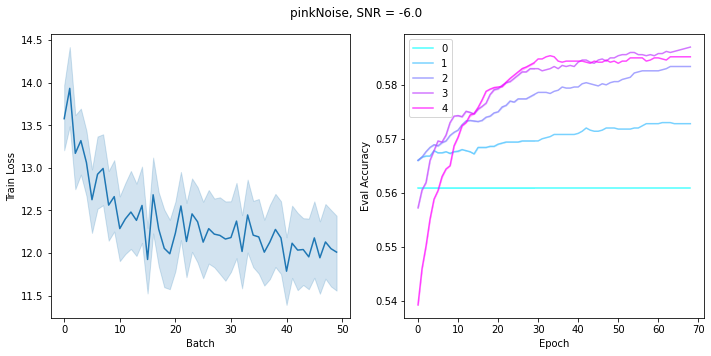




hyper_AudScene_snr-3.0


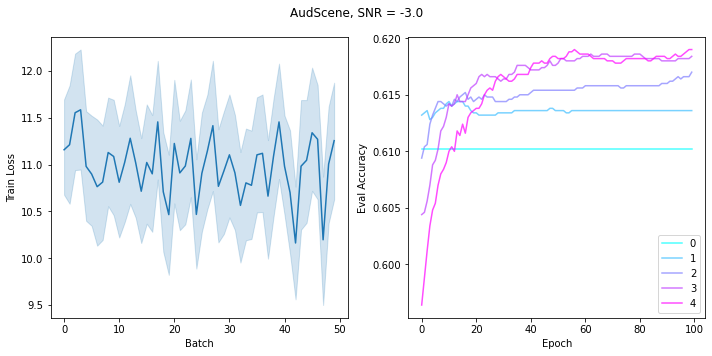




hyper_AudScene_snr0.0


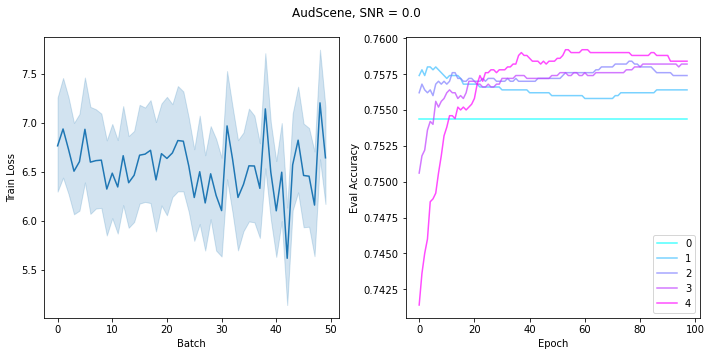




hyper_pinkNoise_snr-9.0


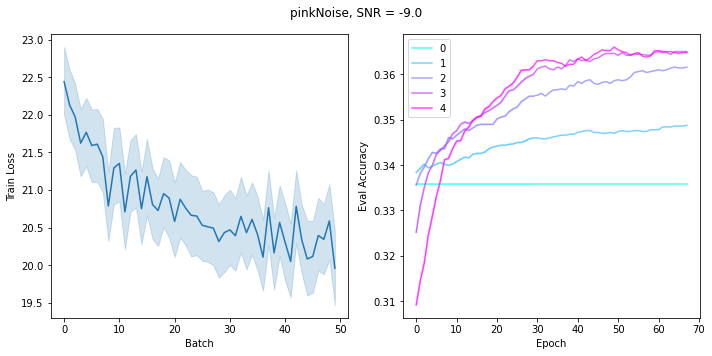




hyper_pinkNoise_snr0.0


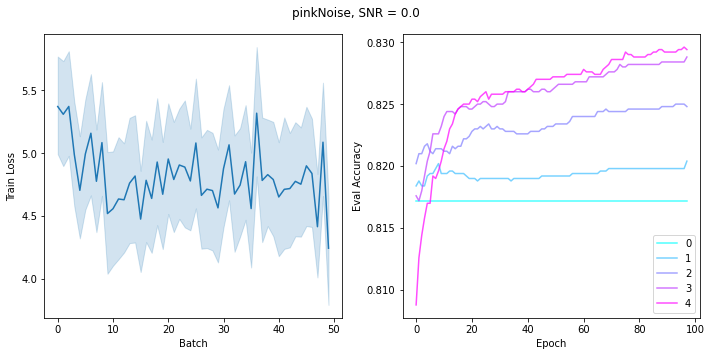




hyper_AudScene_snr-6.0


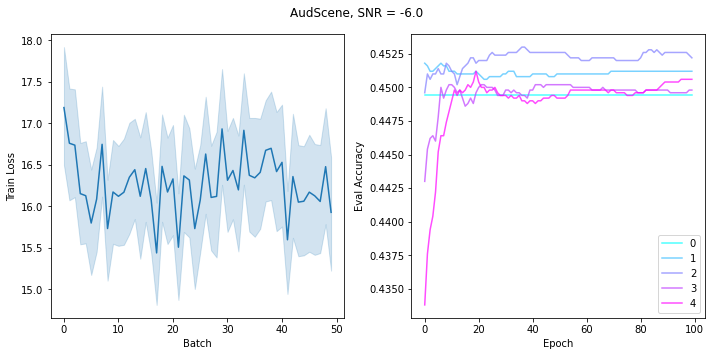




hyper_Babble8Spkr_snr-3.0


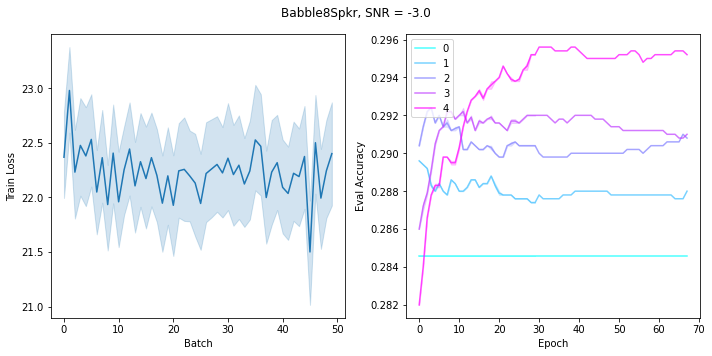




hyper_AudScene_snr3.0


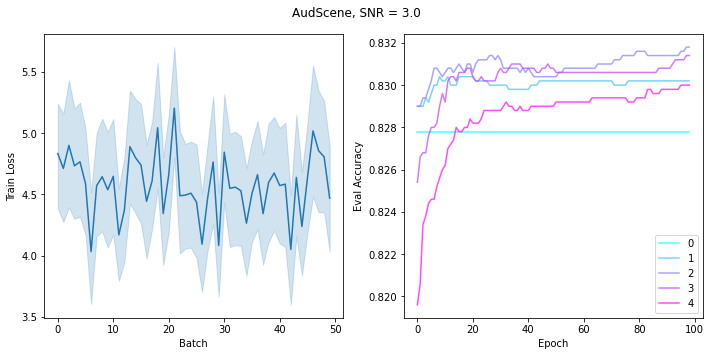




hyper_AudScene_snr-9.0


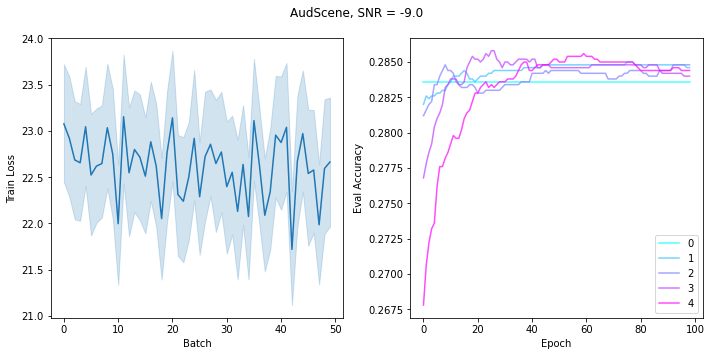




hyper_Babble8Spkr_snr3.0


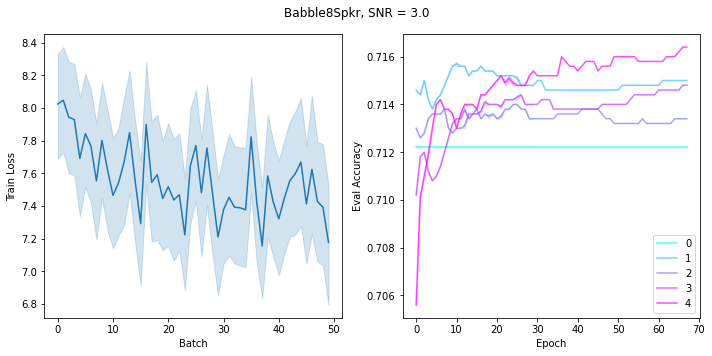




hyper_Babble8Spkr_snr-9.0


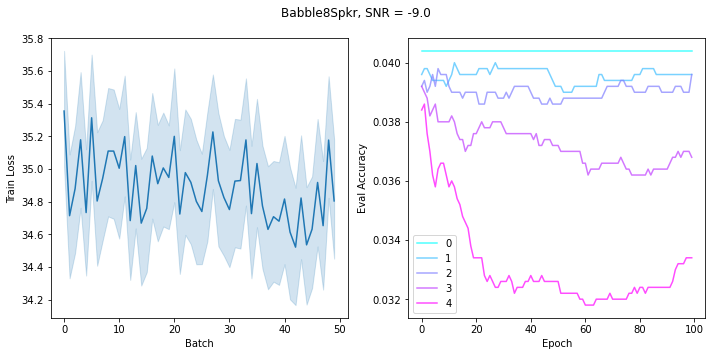




hyper_Babble8Spkr_snr0.0


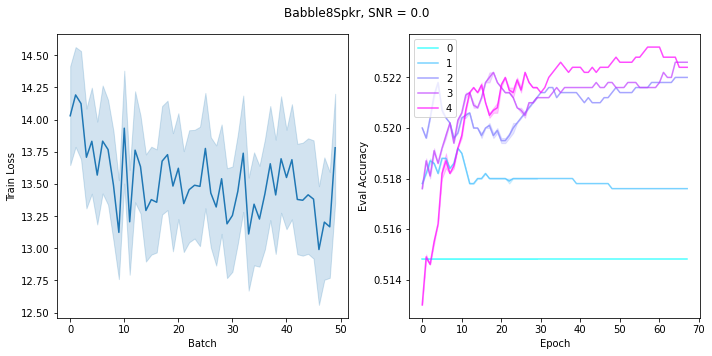




hyper_pinkNoise_snr-3.0


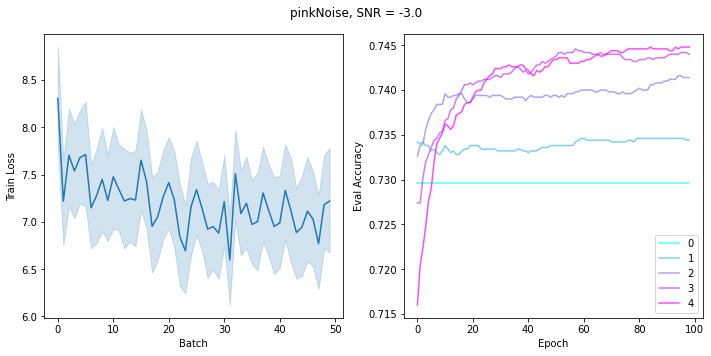

In [19]:
for tfdir in os.listdir(tensorboard_dir):
    if 'hyper' not in tfdir: continue
    if 'shared' in tfdir: continue
    if tfdir == 'small-hyper': continue
    print("====================")
    print(tfdir)
    print("====================")
    noise_info = tfdir.split('_')
    noise_snr = float(noise_info[-1][3:])
    noise_bg = noise_info[1]
    
    # Collect tensorboard files of interest
    tfdir = tensorboard_dir + tfdir + '/'
    tfdir_files = os.listdir(tfdir)
    if not plot_ci:
        if len(tfdir_files) > 1:
            print('More than one TF file; check it is correct.')
        tfdir_files = [tfdir_files[0]]
        
    # Collect losses
    train_loss = []
    train_batch = []
    eval_loss = []
    eval_epoch = []
    eval_timestep = []
    for tfdir_file in tfdir_files:
        tf_file = tfdir + tfdir_file
        ea = event_accumulator.EventAccumulator(tf_file)
        ea.Reload()
        #print('Feedforward error:')
        #print(ea.Scalars(f'FeedForwardPerf/Epoch#0'))
        try:
            _train_loss = [e.value for e in ea.Scalars('TrainingLoss/CE')]
        except:
            continue
        train_loss.extend(_train_loss)
        train_batch.extend([b//200 for b in range(len(_train_loss))])
        epoch = 0
        while True:
            try:
                for timestep in range(5):
                    eval_loss.append(ea.Scalars(f'NoisyPerf/Epoch#{epoch}')[timestep].value)
                    eval_epoch.append(epoch)
                    eval_timestep.append(timestep)
                epoch += 1
            except:
                break

    # Make pandas dataframe
    train_df = pd.DataFrame({
        'Train Loss': train_loss,
        'Batch': train_batch
        })
    eval_df = pd.DataFrame({
        'Eval Accuracy': eval_loss,
        'Epoch': eval_epoch,
        'Timestep': eval_timestep 
        })
                
    fig, axs = plt.subplots(1, 2, figsize = (10,5))
    sns.lineplot(x='Batch', y='Train Loss', ax=axs[0], data=train_df)
    colors = plt.cm.cool(np.linspace(0,1,5))
    for timestep in range(5):
        sns.lineplot(
            x='Epoch', y='Eval Accuracy',
            ax=axs[1],
            data=eval_df[eval_df['Timestep']==timestep],
            color=colors[timestep], label=timestep,
            alpha=0.7
            )
    plt.suptitle(f'{noise_bg}, SNR = {noise_snr}')
    plt.tight_layout()
    plt.show()
    print('\n\n')

In [16]:
# Collect hyperparameters
train_error = []
eval_acc = []
timestep = []
bg = []
snr = []

for tfdir in os.listdir(tensorboard_dir):
    if 'hyper' not in tfdir: continue
    if 'shared' in tfdir: continue
    if tfdir == 'small-hyper': continue
    noise_info = tfdir.split('_')
    noise_snr = float(noise_info[-1][3:])
    noise_bg = noise_info[1]
    
    # Collect tensorboard files of interest
    tfdir = tensorboard_dir + tfdir + '/'
    tfdir_files = os.listdir(tfdir)
    if not plot_ci:
        if len(tfdir_files) > 1:
            print('More than one TF file; check it is correct.')
        tfdir_files = [tfdir_files[0]]
    
    for _iter, tfdir_file in enumerate(tfdir_files):
        tf_file = tfdir + tfdir_file
        ea = event_accumulator.EventAccumulator(tf_file)
        ea.Reload()
        try:
            _train_loss = [e.value for e in ea.Scalars('TrainingLoss/CE')]
        except:
            continue
        for t in range(5):
            try:
                _eval_acc = ea.Scalars(f'NoisyPerf/Epoch#96')[t].value
            except:
                continue
            train_error.append(_train_loss[-1])
            eval_acc.append(_eval_acc)
            timestep.append(t)
            bg.append(noise_bg)
            snr.append(noise_snr)

    # Make pandas dataframe
    df = pd.DataFrame({
        'Training Error': train_error,
        'Eval Accuracy': eval_acc,
        'Timestep': timestep,
        'Background Noise': bg,
        'SNR': snr
        })

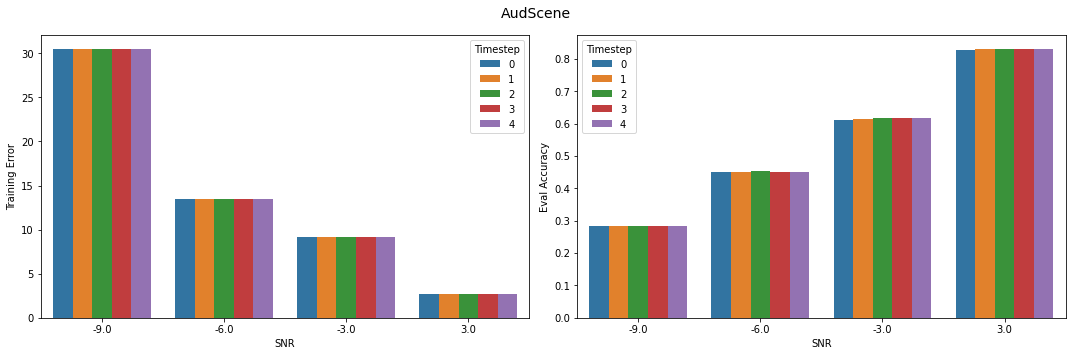

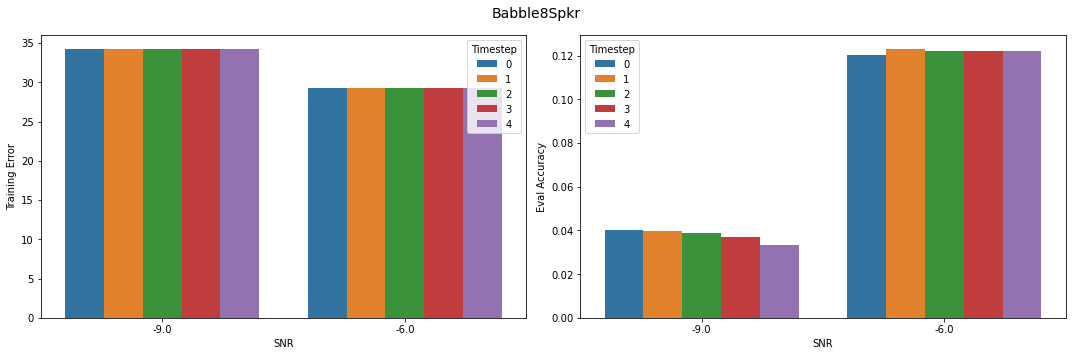

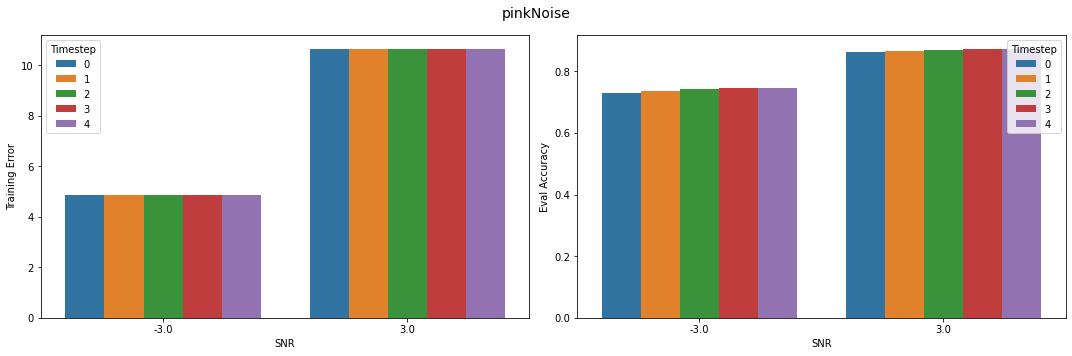

In [17]:
for _bg in np.unique(bg):
    fig, axs = plt.subplots(1, 2, figsize = (15, 5))
    sns.barplot(
        x='SNR', y='Training Error', hue='Timestep',
        ax=axs[0], data=df[df['Background Noise'] == _bg]
        )
    sns.barplot(
        x='SNR', y='Eval Accuracy', hue='Timestep',
        ax=axs[1], data=df[df['Background Noise'] == _bg]
        )
    plt.suptitle(f'{_bg}', fontsize=14)
    plt.tight_layout()
    plt.show()
    print('\n\n')